# Question 2: How much money can you make with Airbnb apartment in Berlin?

The second question around the Airbnb Berlin data set is about the __amount of money that Airbnb home owners earn__ with their listings. Looking at the popularity of neighbourhood groups alone won't allow __people who are interested in renting out apartments on Airbnb__ to fully make up their mind. At the end of the day they want to know __how much money__ they may be able to earn.

Again, the __five steps__ involved in the analysis are as follows:
* 1 - Load libraries
* 2 - Import & understand data
* 3 - Pre-process data
* 4 - Model data
* 5 - Analyze data & evaluate results

## 1 - Load Libraries

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import folium

%matplotlib inline

## 2 - Import & Understand Data

In [3]:
# Import listings data (Source: http://insideairbnb.com/get-the-data.html)
df_listings = pd.read_csv('../data/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20180912025131   2018-09-12   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   

                                             summary  \
0  Great location!  30 of 75 sq meters. This wood...   

                                               space  \
0  A+++ location! This „Einliegerwohnung“ is an e...   

                                         description experiences_offered  \
0  Great location!  30 of 75 sq meters. This wood...                none   

                               neighborhood_overview  \
0  It is located in the former East Berlin area o...   

                                               notes  \
0  This is my home, not a hotel. I rent out occas...   

                                             transit  \
0  Close to U-Bahn U8 and U2 (metro), Trams M12, ...   

                                              access       interaction  \
0  Simple kitchen/cooking, refrigerator, microwav...  Always available   

                                         house_rules  thumbnail_url  \
0  No parties No events No pets No smoking, not e...            NaN   

   medium_url                                        picture_url  \
0         NaN  https://a0.muscache.com/im/pictures/260fd609-7...   

   xl_picture_url  host_id                                host_url host_name  \
0             NaN     2217  https://www.airbnb.com/users/show/2217       Ian   

   host_since                         host_location  \
0  2008-08-18  Key Biscayne, Florida, United States   

                    host_about host_response_time host_response_rate  \
0  Believe in sharing economy.     within an hour               100%   

   host_acceptance_rate host_is_superhost  \
0                   NaN                 t   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/21428a22-4...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/21428a22-4...              Mitte   

   host_listings_count  host_total_listings_count  \
0                  3.0                        3.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t   

  host_identity_verified                   street neighbourhood  \
0                      t  Berlin, Berlin, Germany         Mitte   

  neighbourhood_cleansed neighbourhood_group_cleansed    city   state zipcode  \
0        Brunnenstr. Süd                        Mitte  Berlin  Berlin   10119   

   market   smart_location country_code  country   latitude  longitude  \
0  Berlin  Berlin, Germany           DE  Germany  52.534537  13.402557   

  is_location_exact property_type        room_type  accommodates  bathrooms  \
0                 f    Guesthouse  Entire home/apt             3        1.0   

   bedrooms  beds  bed_type  \
0       1.0   2.0  Real Bed   

                                           amenities  square_feet   price  \
0  {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...          NaN  $60.00   

  weekly_price monthly_price security_deposit cleaning_fee  guests_included  \
0          NaN           NaN          $200.00       $30.00                1   

  extra_people  minimum_nights  maximum_nights calendar_updated  \
0       $28.00               4            1125      6 weeks ago   

  has_availability  availability_30  availability_60  availability_90  \
0                t                5               34               64   

   availability_365 calendar_last_scraped  number_of_reviews first_review  \
0               154            2018-09-12                109   2016-04-11   

  last_review  review_scores_rating  review_scores_accuracy  \
0  2018-09-08                  92.0                     9.0   

   review_score

### 2.1 - Overview

There are __multiple factors__ that have an influence on the income of a single Airbnb listing. On the one hand it's a listing's __price including extra fees__ for additional people. On the other hand it's the __number of nights__ that an Airbnb home is booked. As the data set at hand doesn't include any information on booking histories I will try to come up with an __approximation__ for these variables in order to be able to answer to underlying question of this analysis.

To __simplify the analysis__, the approximation of an Airbnb listing's (minimum) income will be based on a:
* Listing __price__ without additional guests
* Booking duration equal to the __minimum number of nights__
* Booking frequency equal to the __number of reviews per month__

__Attributes__ in the Airbnb data set that can be used to __estimate__ a listing's income:
* neighbourhood_group_cleansed
* price, weekly_price, monthly_price
* minimum_nights, reviews_per_month

## 3 - Pre-Process Data

Again, before starting to model the data it's important to pay close attention to the columns that need to be used and pre-process them or the data set where necessary. Most importantly, I want to be able to __combine previous and future results__ I will apply __similar pre-processing steps__ as used when answering "__Question 1__" where necessary.

### 3.1 - Property Types

First, I'm going to remove listings with property types other than "Apartment".

In [4]:
# Check distriutions of property types
property_count = df_listings["property_type"].value_counts().sum()

# Keep only apartments in analysis (~ 90% of listings)
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


### 3.2 - Missing Values

In [5]:
# Check for missing values
analysis_attributes = ["neighbourhood_group_cleansed","price","weekly_price","monthly_price","minimum_nights","reviews_per_month"]
df_listings[analysis_attributes].isnull().sum()

neighbourhood_group_cleansed        0
price                               0
weekly_price                    16898
monthly_price                   17868
minimum_nights                      0
reviews_per_month                3584
dtype: int64

This time it's not only the column __"reviews_per_month"__ which has __missing values__, but also __"weekly_price"__ and __"monthly_price"__. Whereas missing value of "reviews_per_month" are going to be imputed with 0s, I will __keep the missing values for both price columns__.

In [6]:
# Impute missing values
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

# Check for missing values
df_listings[["reviews_per_month"]].isnull().sum()

reviews_per_month    0
dtype: int64

### 3.3 - Neighbourhoods

The adjustment of text wil be done as in the previous notebook.

In [7]:
# Adjust values of "neighbourhood_group_cleansed"
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

### 3.4 - Bookings Per Month

An income estimation requires as to know the number of bookings a listing receives. The calculation happens according to the way I did it when answering "__Question 1__". Please refere to the previous notebook for more details.

In [8]:
# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

### 3.5 - Price

Let's check out the price columns.

In [9]:
# Check on price columns
df_listings[["price","weekly_price","monthly_price"]].describe()

price weekly_price monthly_price
count    20317         3419          2449
unique     266          366           399
top     $30.00      $300.00     $1,200.00
freq      1340          217           142

Apparently, all three __price columns__ are formatted as objects with a "$" sign in them, I need to convert them to strings in order to remove it. Finally, I can easily convert them to __float values__.

In [10]:
# Convert price columns used in calculation to float
price_cols = ["price","weekly_price","monthly_price"]

for col in price_cols:
    df_listings[col] = df_listings[col].astype(str)
    df_listings[col] = df_listings[col].apply(lambda x: x.replace('$','').replace(',',''))
    df_listings[col] = df_listings[col].astype(float)

Let's see if everything went alright and get some __summary statistics__ on Airbnb listings prices.

In [11]:
# Summary statistics
df_listings["price"].describe()

count    20317.000000
mean        56.948811
std         95.603208
min          0.000000
25%         30.000000
50%         45.000000
75%         65.000000
max       9000.000000
Name: price, dtype: float64

The summary statistics already indicate that prices of Airbnb listings may have a couple of __outliers__. As a listing's income is directly effected by the price, I do expect those outliers to effect my results. For now, I won't do anything about it, but keeping this in mind so I can act on it later.

## 4 - Model Data

Now that the pre-processing step is finished, I'm going to __model the actual income__ of an Airbnb listing. This model mainly involves two things: the __income per booking__ and the number of __bookings per month__. When calculating the income per booking it's important to remember that that Airbnb apartments can sometimes be __booked at different rates__ depending on the duration of the stay. Despite that, I will continue to assume that a booking's duration is equal to the minimum number of nights per booking on average. Thus, "__minimum_nights__" is the column to use as proxy for the duration of a stay.

In [12]:
# Calculate each listing's income per booking
booking_income = []

for (p,wp,mp,n) in zip(df_listings["price"], df_listings["weekly_price"], df_listings["monthly_price"], df_listings["minimum_nights"]):
    price = 0.0
    if n > 29:
        if not math.isnan(mp):
            months = n / 30.0
            price += mp * math.floor(months)
            if not math.isnan(wp):
                weeks = ((months - math.floor(months)) * 30.0) / 7.0
                days = (weeks - math.floor(weeks)) * 7.0
                price += (wp * math.floor(weeks)) + (n * days)
            else:
                days = (months - math.floor(months)) * 30.0
                price += p * days
        elif not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    elif n > 6:
        if not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    else:
        price += p * n
    
    booking_income.append(price)

# Add to data frame and check summary statistics
df_listings["income_per_booking"] = booking_income
df_listings["income_per_booking"].describe()

count     20317.000000
mean        424.786287
std        6709.878161
min           0.000000
25%          60.000000
50%         120.000000
75%         248.000000
max      900000.000000
Name: income_per_booking, dtype: float64

Now, that we have a new column representing the income per booking for an Airbnb listing we need to keep in mind that different bookings are most likely to have different durations as well. In order to make the incomes of listings __more comparable__ to each other we need __transform__ them by multiplying it with the __number of bookings per month__. We then get a new column "__income_per_month__".

In [13]:
# Convert the price per booking to a price per months
df_listings["income_per_month"] = df_listings["income_per_booking"] * df_listings["bookings_per_month"]
df_listings["income_per_month"].describe()

count    20317.000000
mean       162.558356
std        414.960914
min          0.000000
25%          6.000000
50%         44.000000
75%        160.000000
max      27000.000000
Name: income_per_month, dtype: float64

## 5 - Analyze Data & Evaluate Results

### 5.1 - Income Per Month

First things first: The summary statistics on the pre-processed price column as well as the income per month already indicate the __presence of outliers__ within the data set. Maybe a __scatterplot__ makes it easier to understand what's really going on.

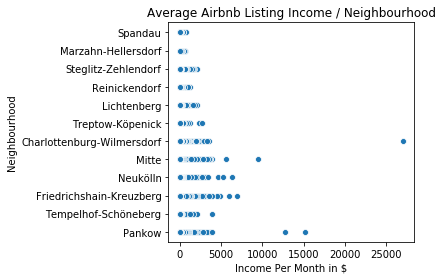

In [14]:
# Plot scatterplot in order to identify outliers
sns.scatterplot(x="income_per_month", y="neighbourhood_group_cleansed", data=df_listings)
plt.title("Average Airbnb Listing Income / Neighbourhood", fontsize=12)
plt.ylabel("Neighbourhood", fontsize=10)
plt.xlabel("Income Per Month in $", fontsize=10)
plt.tight_layout()

It looks like that only __some of the neighbourhoods__ produce these outliers. Eventhough it's not clear what the reasons for these extreme data points are, it's important to __remove__ them so they won't influence the final results.

In [15]:
# Remove upper 5% from data set
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["income_per_month"] <= df_listings["income_per_month"].quantile(.95)]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

1016 records were removed from the Airbnb Berlin listings data frame.


Next up I want to continue with a neighbourhood group comparison of income. To get a better feeling of how a listing's price as well as bookings per month relate to the income, I will try to plot these together.

In [16]:
# Mean listing income / neighbourhood
# Grouping functions
f = {"id":["count"], "income_per_month":["mean"], "bookings_per_month":["mean"], "price":["mean"],
     "latitude":["mean"], "longitude":["mean"]}

# Grouping
hood_income = df_listings[["neighbourhood_group_cleansed","id","income_per_month","bookings_per_month","price","latitude","longitude"]]
hood_income = hood_income.groupby("neighbourhood_group_cleansed", as_index=False).agg(f)
hood_income.columns = ["neighbourhood_group","num_listings","income_per_month","bookings_per_month","price","latitude","longitude"]
hood_income = hood_income.sort_values("neighbourhood_group")

# Show top 5 highest earning neighbourhoods
hood_income[["neighbourhood_group","income_per_month"]].sort_values("income_per_month", ascending=False).head()

neighbourhood_group  income_per_month
3         Marzahn-Hellersdorf        126.474068
4                       Mitte        115.385053
6                      Pankow        111.688933
0  Charlottenburg-Wilmersdorf        110.371235
8                     Spandau        109.058243

In [17]:
# Plot comparison
fig, ax = plt.subplots(1,3, figsize = (16,4))
sns.set(style = "white")
sns.barplot(x="neighbourhood_group", y="income_per_month", data=hood_income, ax = ax[0])
sns.barplot(x="neighbourhood_group", y="bookings_per_month", data=hood_income, ax = ax[1])
sns.barplot(x="neighbourhood_group", y="price", data=hood_income, ax = ax[2])

# Format plot
ax[0].set_xticklabels(hood_income["neighbourhood_group"].values, rotation=90)
ax[0].set_title("Listing Income / Neighbourhood", fontsize=14)
ax[0].set_xlabel("Neighbourhood Group", fontsize=12)
ax[0].set_ylabel("Listing Income Per Month in $", fontsize=12)
ax[1].set_xticklabels(hood_income["neighbourhood_group"].values, rotation=90)
ax[1].set_title("Number of Bookings / Neighbourhood", fontsize=14)
ax[1].set_xlabel("Neighbourhood Group", fontsize=12)
ax[1].set_ylabel("Bookings Per Month", fontsize=12)
ax[2].set_xticklabels(hood_income["neighbourhood_group"].values, rotation=90)
ax[2].set_title("Price Per Night / Neighbourhood", fontsize=14)
ax[2].set_xlabel("Neighbourhood Group", fontsize=12)
ax[2].set_ylabel("Price Per Night in $", fontsize=12)

# Add mean as reference line
ax[0].axhline(hood_income["income_per_month"].mean(), ls='--');
ax[1].axhline(hood_income["bookings_per_month"].mean(), ls='--');
ax[2].axhline(hood_income["price"].mean(), ls='--');

With __\$126.47 Marzahn-Hellersdorf__ leads the neighbourhood groups in Berlin in terms of recurring monthly income of Airbnb listings in Berlin. They are followed by __Mitte__ with __\$115.39__ as well as Pankow, Charlottenburg-Wilmersdorf and Spandau. Also, it's these 5 neighbourhoods only that earn __more money than average__ which lies at a __\$100.27__. What's also interesting to point out here is that the income is does not seem to follow the distribution of neither the number of bookings nor the price of Airbnb apartments in Berlin.

Barcharts as the ones plotted above a really helpful to understand the differences between the 12 neighbourhood groups in Berlin. However, what's really missing at that point is a way to __locate them on a map__. So, let's try to do that by creating a simple __choropleth map__ of Berlin showing the average listing incomes per month across different neighbourhood groups. In order to do so, I start with importing a __geojson object__ which holds all the map relevant information.

In [18]:
# Load geojson object
# Source:
# https://data.technologiestiftung-berlin.de/dataset/bezirksgrenzen
berlin_hoods = os.path.join("../data/berlin_neighbourhood_groups.geojson")
geo_json_data = json.load(open(berlin_hoods))

After importing the geojson object it's important to __adjust the formatting__ of the data that goes into the map.

In [19]:
# Create income dictionary
income_dict = hood_income.set_index("neighbourhood_group")["income_per_month"]
income_dict["Mitte"]

115.38505345888349

Finally, I can plot the map.

In [183]:
# Draw choropleth map (let folium determine the scale)
#hood_map = folium.Map(location=[52.534537, 13.402557], zoom_start=10)
hood_map.choropleth(geo_data=geo_json_data, data=income_dict,
                    key_on="feature.properties.Gemeinde_name",
                    fill_color="OrRd", fill_opacity=0.7, line_opacity=0.2,
                    legend_name="Average Airbnb Listing Income Per Month in $")

hood_map.save("../data/airbnb_income_neighbourhoods.html")
hood_map

Unfortunately, I couldn't get the labels to work with the choropleth map. Nonetheless, from the different colors we can already see which neighbourhood groups are the winners in termin average listing income per month. The dark red areae in the east represents __Marzahn-Hellersdorf__. __Mitte__ - which actually is the German word for "center" - is the one directly in the center having __Pankow__ in its north-east as well as __Charlottenburg-Wilmersdorf__ in its south-west.